<h1><center><strong><font size='20'>Predicting Diabetes</font></strong></center></h1>
<h3><center>Data obtained from Kaggle</center></h3>
<h3><center><em>https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?resource=download</em></center></h3>

## Installations

In [89]:
pip install xgboost, shap

     -------------------------------------- 462.3/462.3 kB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Imports

In [242]:
import os
from pprint import pprint
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import shap

## Read in Data

In [167]:
path = os.getcwd()
df = pd.read_csv(f'{path}\\diabetes_binary_health_indicators_BRFSS2015.csv')

## Explore/Prepare Data

In [168]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [169]:
# Check for imbalances
diab_perc = round((len(df[df.Diabetes_binary == 1]) / len(df)) * 100, 2)
print(f'{diab_perc}% of surveyed individuals have diabetes.')

13.93% of surveyed individuals have diabetes.


In [170]:
min_bmi = df.BMI.min()
max_bmi = df.BMI.max()
bmi_val_count = len(df.BMI.unique())

print(f'The minimum bmi is {min_bmi}\n')
print(f'The maximum bmi is {max_bmi}\n')
print(f'There are {bmi_val_count} unique bmi values')

The minimum bmi is 12.0

The maximum bmi is 98.0

There are 84 unique bmi values


In [171]:
# categorize individuals as Underweight (0), Healthy Weight (1), Overweight (2), or Obese (3)
df['weight_class'] = np.where(df.BMI < 18.5, 0, \
                           np.where(df.BMI < 24.9, 1, \
                                   np.where(df.BMI < 29.9, 2, 3)
                                   )
                           )

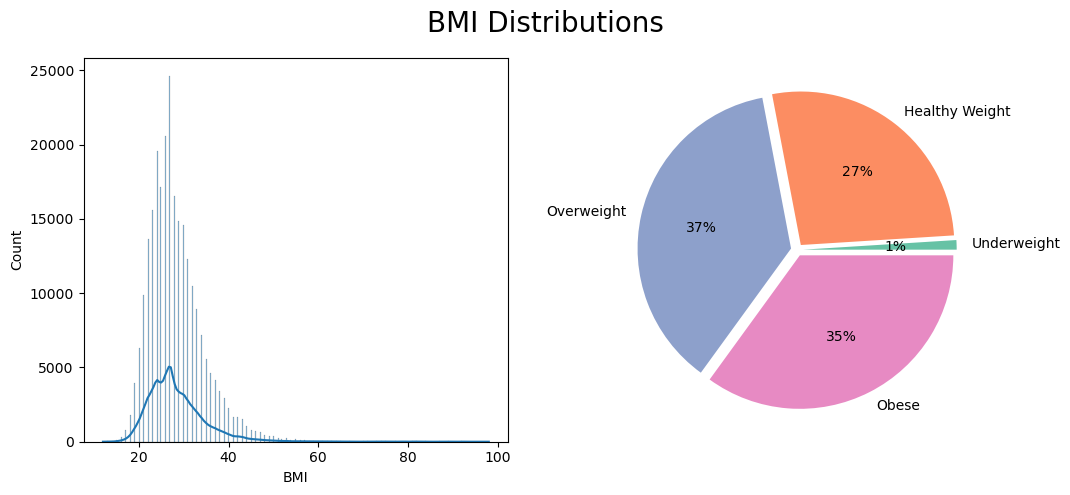

In [172]:
labels = ['Underweight', 'Healthy Weight', 'Overweight', 'Obese']
data = [round((len(df[df.weight_class == i]) / len(df)) * 100, 0) for i in range(4)]
explode = [0.04, 0.04, 0.04, 0.04]

#define Seaborn color palette to use
colors = sns.color_palette('Set2')[:4]

fig, ax = plt.subplots(1, 2, figsize=(11,5))
ax = ax.ravel()


ax[1] = plt.pie(
    data,
    colors = colors,
    labels = labels,
    explode = explode,
    autopct='%.0f%%'
)

sns.histplot(
    data=df.BMI,
    kde = True,
    ax = ax[0]
)

fig.suptitle('BMI Distributions', size=20)
fig.tight_layout()

In [173]:
df.columns.unique()

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'weight_class'],
      dtype='object')

In [174]:
df.PhysHlth.unique()

array([15.,  0., 30.,  2., 14., 28.,  7., 20.,  3., 10.,  1.,  5., 17.,
        4., 19.,  6., 12., 25., 27., 21., 22.,  8., 29., 24.,  9., 16.,
       18., 23., 13., 26., 11.])

In [175]:
# dummy encode weight_class
pd.get_dummies(data = df, prefix='wclass', columns = ['weight_class'], drop_first=True)
# drop BMI since that information is captured in weight_class
df.drop(columns=['BMI'], inplace=True)

In [176]:
test_data = df.copy(deep=True)

<center><h1>Initial Model: Logistic Regression</h1></center>

<center><h3><em> Assumption 1: Correct Outcome Type</h3></em>
Model Predicts Binary as expected</center>


<center><h3><em> Assumption 2: Linearity</h3></em>
Ensure continuous variables are linearly related to the log-odds<br>
I use a Box-Tidwell Test</center>

In [177]:
cols_to_keep = ['PhysHlth', 'MentHlth']

for col in cols_to_keep:
    test_data[f'{col}_inter'] = test_data[col].apply(lambda x : x * np.log(x))
    #cols_to_keep.append(f'{col}_inter')
    

X = test_data.dropna()[['PhysHlth', 'MentHlth', 'PhysHlth_inter', 'MentHlth_inter']]
y = test_data.dropna().Diabetes_binary

X_constant = sm.add_constant(X, prepend=False)

logit_results = sm.GLM(y, X_constant, family=sm.families.Binomial()).fit()

print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Diabetes_binary   No. Observations:                43933
Model:                            GLM   Df Residuals:                    43928
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21503.
Date:                Wed, 09 Aug 2023   Deviance:                       43005.
Time:                        13:49:28   Pearson chi2:                 4.39e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03582
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
PhysHlth           0.2270      0.014     15.

In [178]:
ment_log_odds = []

for val in test_data.MentHlth.unique():
    p = len(test_data[test_data.MentHlth == val]) / len(test_data)
    ment_log_odds.append(np.log(p/(1-p)))
    
phys_log_odds = []

for val in test_data.PhysHlth.unique():
    p = len(test_data[test_data.PhysHlth == val]) / len(test_data)
    phys_log_odds.append(np.log(p/(1-p)))

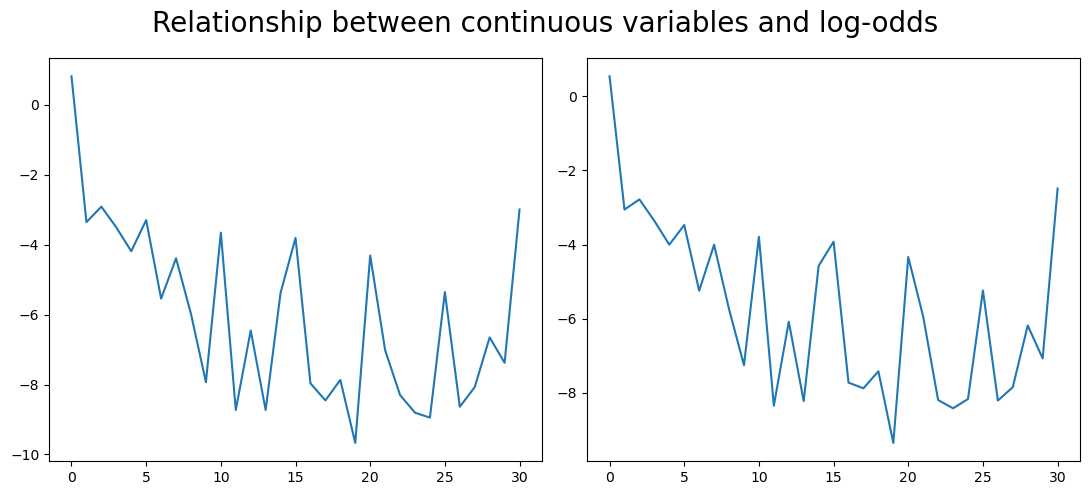

In [179]:
fig, ax = plt.subplots(1, 2, figsize=(11,5))
ax = ax.ravel()


sns.lineplot(
    x=test_data.MentHlth.unique(),
    y=ment_log_odds,
    ax=ax[0]
)

sns.lineplot(
    x=test_data.PhysHlth.unique(),
    y=phys_log_odds,
    ax=ax[1]
)

fig.suptitle('Relationship between continuous variables and log-odds', size=20)
fig.tight_layout()

PhysHlth and MentHlth are not linearly related to the log-odds; therefore, we must drop these columns.

<center><h3><em> Assumption 3: Absence of Multicollinearity</h3></em>
No need to test since continuous variables are dropped</center>

<center><h3><em> Assumption 4: Independent Observations</h3></em>
Naturally assumed to be satisfied</center>

## Building the model

In [236]:
log_reg_data = df.copy(deep=True)

X = log_reg_data[[col for col in log_reg_data.columns if col != 'Diabetes_binary']]
y = log_reg_data.Diabetes_binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

log_model = LogisticRegression(class_weight='balanced', max_iter=500).fit(X_train, y_train)

predictions = log_model.predict(X_test)

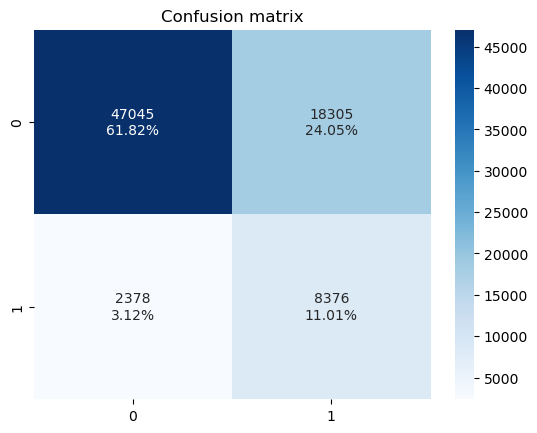

Accuracy: 72.82%
Recall: 77.89%


In [237]:
accuracy = '{:.2%}'.format(accuracy_score(y_test, predictions))
recall = '{:.2%}'.format(recall_score(y_test, predictions))
cm = confusion_matrix(y_test, predictions)

group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percs = [f'{round((val / np.sum(cm)) * 100, 2)}%' for val in cm.flatten()]

labels = [f'{count}\n{perc}' for count, perc in zip(group_counts, group_percs)]
labels = np.asarray(labels).reshape(2,2)

# labels

cm_plot = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion matrix')
plt.show()
print(f'Accuracy: {accuracy}\nRecall: {recall}')

<center><h1>Second Model: XGBoost</h1>
XGBoost only assumes an ordinal relationship between numeric variables. This is satisfied.</center>

In [243]:
xg_data = df.copy(deep=True)

X = xg_data[[col for col in xg_data if col != 'Diabetes_binary']]
y = xg_data.Diabetes_binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# initial model before optimization
xgb_model = XGBClassifier().fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

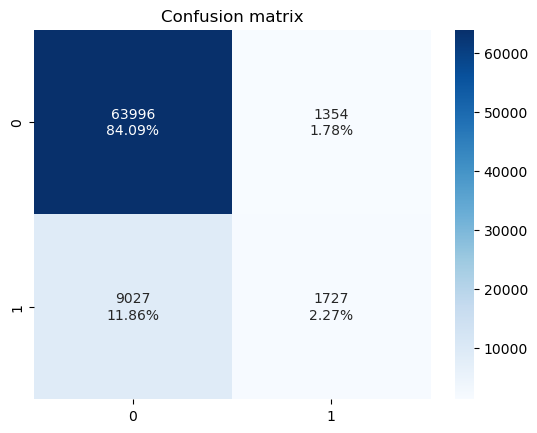

Accuracy: 86.36%
Recall: 16.06%


In [245]:
xgb_accuracy = '{:.2%}'.format(accuracy_score(y_test, y_pred))
xgb_recall = '{:.2%}'.format(recall_score(y_test, y_pred))
xgb_cm = confusion_matrix(y_test, y_pred)

xgb_group_counts = ['{0:0.0f}'.format(value) for value in
                xgb_cm.flatten()]
xgb_group_percs = [f'{round((val / np.sum(cm)) * 100, 2)}%' for val in xgb_cm.flatten()]

labels = [f'{count}\n{perc}' for count, perc in zip(xgb_group_counts, xgb_group_percs)]
labels = np.asarray(labels).reshape(2,2)

# labels

xgb_cm_plot = sns.heatmap(xgb_cm, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion matrix')
plt.show()
print(f'Accuracy: {xgb_accuracy}\nRecall: {xgb_recall}')

In [247]:
# deal with imbalance
new_xgb_model = XGBClassifier(scale_pos_weight=(sum(y_pred[y_pred==0]) / sum(y_pred[y_pred==1]))).fit(X_train, y_train)
new_y_pred = new_xgb_model.predict(X_test)

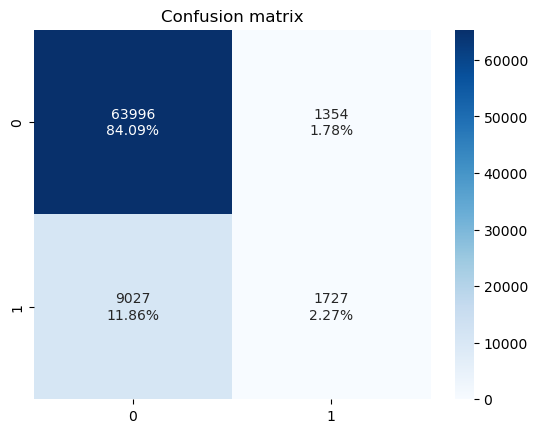

Accuracy: 85.87%
Recall: 0.00%


In [250]:
new_xgb_accuracy = '{:.2%}'.format(accuracy_score(y_test, new_y_pred))
new_xgb_recall = '{:.2%}'.format(recall_score(y_test, new_y_pred))
new_xgb_cm = confusion_matrix(y_test, new_y_pred)

new_xgb_group_counts = ['{0:0.0f}'.format(value) for value in
                new_xgb_cm.flatten()]
new_xgb_group_percs = [f'{round((val / np.sum(cm)) * 100, 2)}%' for val in new_xgb_cm.flatten()]

new_xgb_labels = [f'{count}\n{perc}' for count, perc in zip(new_xgb_group_counts, new_xgb_group_percs)]
new_xgb_labels = np.asarray(labels).reshape(2,2)

new_xgb_cm_plot = sns.heatmap(new_xgb_cm, annot=new_xgb_labels, fmt='', cmap='Blues')
plt.title('Confusion matrix')
plt.show()
print(f'Accuracy: {new_xgb_accuracy}\nRecall: {new_xgb_recall}')

In [252]:
# Use GridSearch to find optimal hyper parameters
param_grid = {'learning_rate': (0.0001,0.001,0.01,0.05,0.1,0.15),
              'scale_pos_weight' : (sum(y_pred[y_pred==0]) / sum(y_pred[y_pred==1]), 1)
              
                 }

# use gridsearch to test all values
xgb_gscv = GridSearchCV(new_xgb_model, param_grid, cv=5)
# fit model to data
xgb_gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max

In [253]:
print(xgb_gscv.best_params_)

{'learning_rate': 0.1, 'scale_pos_weight': 1}


In [255]:
optimal_xgb_model = XGBClassifier(
    learning_rate=0.1,
    scale_pos_weight=1
).fit(X_train, y_train)

opt_y_pred = optimal_xgb_model.predict(X_test)

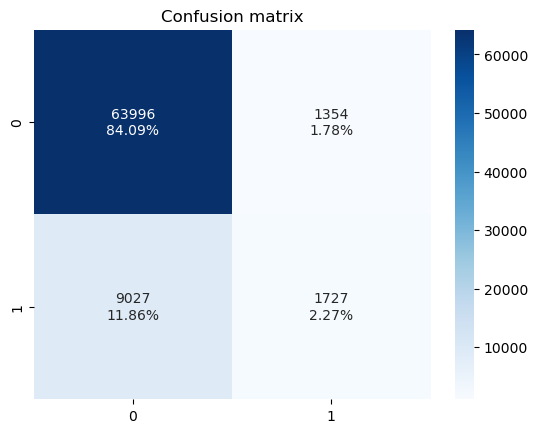

Accuracy: 86.56%
Recall: 15.28%


In [256]:
optimal_xgb_accuracy = '{:.2%}'.format(accuracy_score(y_test, opt_y_pred))
optimal_xgb_recall = '{:.2%}'.format(recall_score(y_test, opt_y_pred))
optimal_xgb_cm = confusion_matrix(y_test, opt_y_pred)

optimal_xgb_group_counts = ['{0:0.0f}'.format(value) for value in
                optimal_xgb_cm.flatten()]
optimal_xgb_group_percs = [f'{round((val / np.sum(cm)) * 100, 2)}%' for val in optimal_xgb_cm.flatten()]

optimal_xgb_labels = [f'{count}\n{perc}' for count, perc in zip(new_xgb_group_counts, new_xgb_group_percs)]
optimal_xgb_labels = np.asarray(labels).reshape(2,2)

optimal_xgb_cm_plot = sns.heatmap(optimal_xgb_cm, annot=optimal_xgb_labels, fmt='', cmap='Blues')
plt.title('Confusion matrix')
plt.show()
print(f'Accuracy: {optimal_xgb_accuracy}\nRecall: {optimal_xgb_recall}')